# Generating Secondary Eclipse Emission Spectra

This demonstrates how to compute the emission spectrum of a transiting exoplanet at secondary eclipse (i.e. $F_p / F_*$).

### Stellar Spectrum

Since emission spectra are normalised to the stellar flux, we need to know $F_*$. POSEIDON can automatically compute $F_*$ when initialising the star object, either by interpolating grids of stellar models to the provided stellar properties or assuming a black body.

Let's start by loading a PHOENIX stellar spectrum with stellar properties corresponding to WASP-17.

In [2]:
from POSEIDON.core import create_star, wl_grid_constant_R
from POSEIDON.constants import R_Sun

#***** Create wavelength grid for our star and planet spectrum *****#
 
wl_min = 0.2      # Minimum wavelength (um)
wl_max = 15.0     # Maximum wavelength (um)
R = 1000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define stellar properties *****#

# Stellar properties below from ExoMast for WASP-121

R_s = 1.583*R_Sun      # Stellar radius (m)
T_s = 6550.0          # Stellar effective temperature (K)
Met_s = -0.25          # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)] <--- note: for PHOENIX, only the solar metallicity models are used  
log_g_s = 4.149        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

We can quickly plot the stellar spectrum.

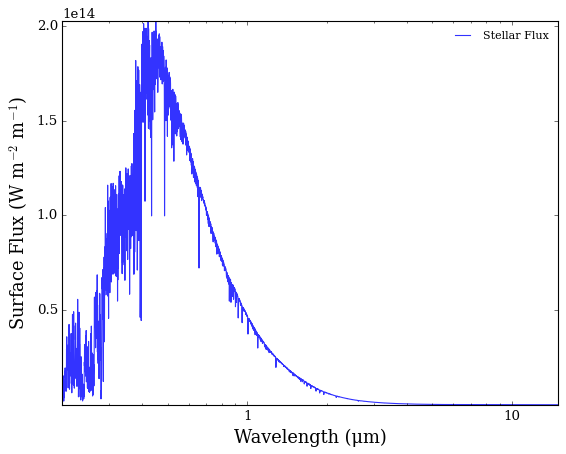

In [3]:
from POSEIDON.visuals import plot_stellar_flux

F_s = star['F_star']
wl_s = star['wl_star']

# Plot the stellar spectrum
fig_star = plot_stellar_flux(F_s, wl_s)

### A Simple Dayside Model

Let's construct a simple model atmosphere with a vertical temperature gradient (as we'll see later, emission spectra are very sensitive to the pressure-temperature profile).

We first provide the planet properties for WASP-17b.

In [4]:
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J, M_J

#***** Define planet properties *****#

planet_name = 'WASP-17b'  # Planet name used for plots, output files etc.

R_p = 1.932*R_J    # Planetary radius (m)
M_p = 0.477*M_J    # Mass of planet (kg)
T_eq = 1755          # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, T_eq = T_eq)

This time, we'll choose a 'gradient' P-T profile instead of an isotherm.

In [6]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'ATMO'

bulk_species = ['H2', 'He']
param_species = ['CO','CO2','H2O','Na','K','CH4']
# Create the model objects
model = define_model(model_name, bulk_species, param_species, 
                       PT_profile = 'file_read', X_profile = 'file_read',
                       radius_unit = 'R_J', surface = True)

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['R_p_ref' 'log_P_surf' 'log_CO' 'log_CO2' 'log_H2O' 'log_Na' 'log_K'
 'log_CH4']


Next, we choose specific values of the model parameters to create an atmosphere. We'll use $T_{\rm{high}}$ = 1500 K and $T_{\rm{deep}}$ = 3000 K.

In [7]:
from POSEIDON.core import make_atmosphere
from POSEIDON.utility import read_PT_file
import numpy as np

# Specify the pressure grid of the atmosphere
P_min = 1.0e-6    # 1 ubar
P_max = 3.72e2      # 100 bar
N_layers = 51    # no. of layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Add the surface pressure
P_surf = 4e2

# Specify the reference pressure and radius
P_ref = P_surf   # Reference pressure (bar)
R_p_ref = R_p    # Radius at reference pressure

# Specify location of the P-T profile file
PT_file_dir = '/home/gauravs/APAM/RT_code/WASP17/'
PT_file_name_1 = 'pt-eqpt_WASP-017_0.50_+0.0_0.55_model.txt'

# Read the P-T profile files
T_Modern = read_PT_file(PT_file_dir, PT_file_name_1, P, skiprows=0, 
                        P_column = 1, T_column = 2)

# # Generate the atmosphere
# atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
#                              PT_params, log_X_params)

In [8]:
from POSEIDON.utility import read_chem_file

# Specify location of the composition file
chem_file_dir = '/home/gauravs/APAM/RT_code/WASP17/'
chem_file_name_1 = 'chem-eqpt_WASP-017_0.50_+0.0_0.55_model.txt'
#chem_file_name_2 = 'TRAPPIST-1e_1.0bar_100xCO2_Archean_chem.txt'

chem_species_file = ['mm','H2', 'O-3P', 'O-1D', 'CO', 'C', 'CH', '3CH2', '1CH2', 'H2O', 'O2', 'H2O2', 'CH4',
 'H2CO', 'CH3OH', 'CO2', 'CH3OOH', 'C2H2', 'C2H4', 'C2H6', 'CH2CO', 'CH3CHO',
 'C2H5OH', 'C2H5OOH', 'CH3COOOH', 'C3H8', 'C4H8Y', 'C4H10', 'C2H5CHO', 'C3H7OH',
 'C2H6CO', 'C3H8CO', 'C2H3CHOZ', 'cC2H4O', 'H', 'C7H8', 'OH', 'OOH', 'CH3', 'HCO',
 'CH2OH', 'CH3O', 'CH3OO', 'C2H', 'C2H3', 'C2H5', 'CHCO', 'CH2CHO', 'CH3CO', 'C2H5O',
 'C2H4OOH', 'C2H5OO', 'CH3COOO', '1C3H7', '1C4H9', 'CH3OCO', 'CO2H', '2C2H4OH',
 '1C2H4OH', '2C3H7', '2C4H9', 'N2', 'He', 'Ar', 'N-4S', 'N-2D', 'NH', 'NH2', 'NH3',
 'NNH', 'NO', 'NO2', 'N2O', 'NCN', 'HNO', 'CN', 'HCN', 'H2CN', 'HCNN', 'HCNO', 'HOCN',
 'HNCO', 'HON', 'NCO', 'HNO2', 'HONO', 'NO3', 'HONO2', 'CH3ONO', 'CH3NO2', 'CH3NO',
 'C3H7O', 'C4H9O', 'cC6H6', 'N2O3', 'NH2OH', 'N2O4', 'N2H2', 'N2H3', 'N2H4', 'HNNO',
 'HNOH', 'HNO3', 'H2NO', 'CNN', 'H2CNO', 'C2N2', 'HCNH', 'Na', 'NaH', 'NaO', 'NaOH',
 'NaCl', 'NaF', 'K', 'KH', 'KO', 'KOH', 'KCl', 'KF', 'HO2', 'SO', 'SO2', 'Cl', 'HCl', 'ClO', 'Cl2',
 'Ti', 'TiO', 'V', 'VO', 'Si', 'SiH', 'SiO', 'SiS', 'S', 'SH', 'H2S', 'Mg', 'MgH', 'MgS', 'Al', 'AlH',
 'AlOH', 'Al2O', 'Al2O3', 'Fe', 'FeH', 'Cr', 'CrN', 'CrO', 'Ca', 'CaH', 'CaOH', 'F', 'HF', 'Li',
 'LiCl', 'LiH', 'LiF', 'Cs', 'CsCl', 'CsH', 'CsF', 'Rb', 'RbCl', 'RbH', 'RbF', 'P',
 'PH', 'PH3', 'PO', 'P2', 'PS', 'PH2', 'P4O6', 'H+', 'H_', 'Na+', 'K+', 'e_', 'C+', 'He+', 'Ca+', 'Si+', 
 'Ca(a)', 'Ca(b)', 'Ca(l)', 'Ti3O5(a)', 'Ti3O5(b)', 'Ti3O5(l)', 'Ti(a)', 'Ti(b)', 'Ti(l)', 'TiO(a)', 
 'TiO(b)', 'TiO(l)', 'V(cr)', 'V(l)', 'VO(s)', 'VO(l)', 'V2O3(s)', 'V2O3(l)', 'V2O4(a)', 'V2O4(b)',
 'V2O4(l)', 'V2O5(s)', 'V2O5(l)', 'Cr(a)', 'Cr(b)', 'Cr(l)', 'Na2S(a)', 'Na2S(b)',
 'Na2S(l)', 'Na3AlF6(a)', 'Na3AlF6(b)', 'Na3AlF6(l)', 'K2S(a)', 'K2S(b)', 'K2S(c)', 'K2S(l)', 'KCl(l)', 'KCl(s)', 'Na(l)',
 'Na(cr)', 'K(l)', 'K(cr)', 'S(l)', 'S(cr1)', 'S(cr2)', 'NaCl(l)', 'NaCl(s)',
 'MgSiO3(a)', 'MgSiO3(b)', 'MgSiO3(c)', 'MgSiO3(l)', 'Mg2SiO4(s)', 'Mg2SiO4(l)',
 'MgAl2O4(s)', 'MgAl2O4(l)', 'Al2O3(a)', 'Al2O3(l)', 'SiO2(hqz)', 'SiO2(l)',
 'NaAlSi3O8(', 'Na2O(l)', 'Na2O(a)', 'Na2O(c)', 'NaAlSiO4(', 'KAlSi2O6(', 'Fe(a)',
 'Fe(b)', 'Fe(c)', 'Fe(d)', 'Fe(l)', 'FeS(a)', 'FeS(b)', 'FeS(c)', 'FeS(l)',
 'H2O(l)', 'H2O(s)', 'NH3(l)', 'NH3(s)', 'Cr2O3(a)', 'Cr2O3(b)', 'Cr2O3(c)',
 'Cr2O3(d)', 'Cr2O3(l)', 'LiAlO2(s)', 'LiAlO2(l)', 'LiF(cr)', 'CsCl(a)', 'CsCl(b)',
 'CsCl(l)', 'RbCl(cr)', 'RbCl(l)', 'H3PO4(l)', 'H3PO4(cr)']  

# Read the composition files
X_Modern = read_chem_file(chem_file_dir, chem_file_name_1, P, chem_species_file, 
                          chem_species_in_model = model['chemical_species'], 
                          skiprows = 0)


In [9]:
from POSEIDON.core import make_atmosphere

# Generate the atmospheres
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                               T_input = T_Modern, X_input = X_Modern,    # Provide T and X directly here
                               P_surf = P_surf) 



Let's see what our atmosphere looks like.

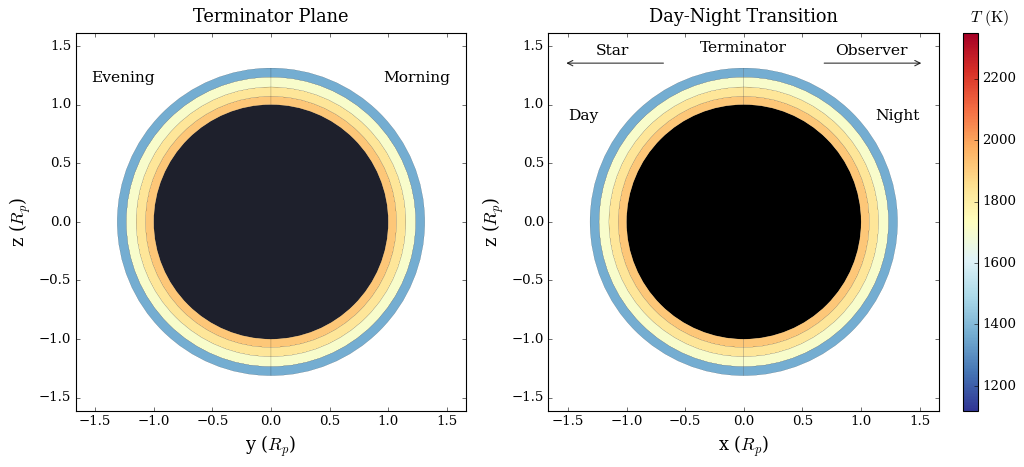

In [10]:
from POSEIDON.visuals import plot_geometry, plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_geom = plot_geometry(planet, star, model, atmosphere)

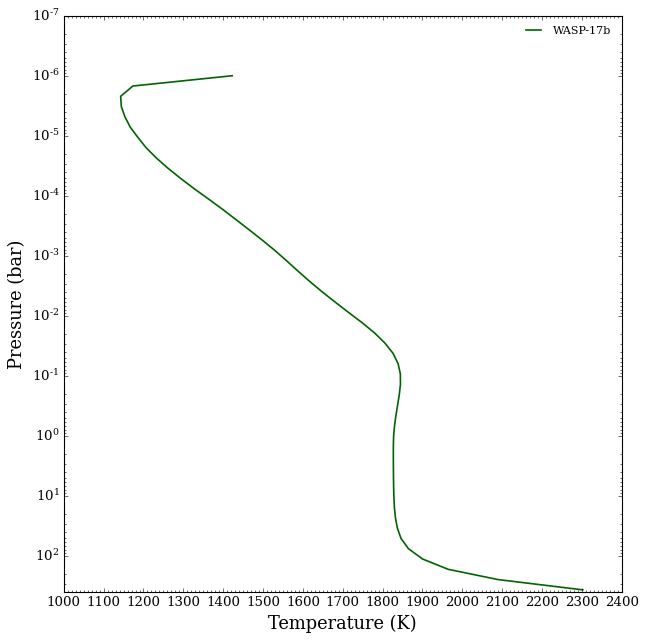

In [14]:
# plotting the P-T profiles first
fig_PT_1 = plot_PT(planet, model, atmosphere, T_min = 1000, T_max = 2400,       # This demonstrates several plot customisation options
                   log_P_max = np.log10(P_surf), log_P_min=np.log10(1e-7),PT_label = 'WASP-17b',
                   legend_location = 'upper right', colour = 'darkgreen')

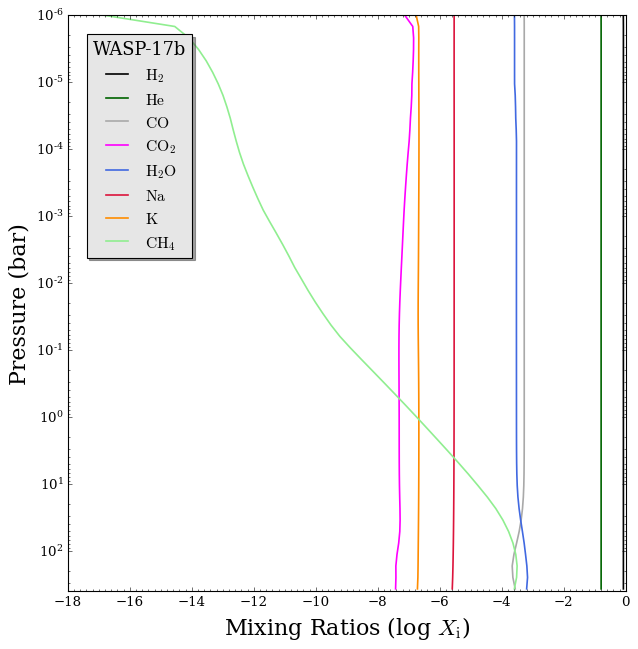

In [15]:
# Compare the mixing ratio profiles
fig_chem_1 = plot_chem(planet, model, atmosphere, log_P_max = np.log10(P_surf),
                       legend_title = 'WASP-17b', legend_location = 'upper left',
                       colour_list = ['black', 'darkgreen', 'darkgrey', 'magenta',   # Here you can override the default colours
                                      'royalblue', 'crimson', 'darkorange', 'lightgreen'])


Note that the dayside and nightside of this planet actually both share the same P-T profile, since this is a 1D model (the only atmospheric variations are in the radial direction).

Now let's read in the opacities for our model.

In [13]:
from POSEIDON.core import read_opacities

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 1000    # 1000 K lower limit
T_fine_max = 2500    # 2500 K upper limit
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar lower limit
log_P_fine_max = 2.0    # 100 bar
log_P_fine_step = 0.2   # steps

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac_sampling = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
CO done
CO2 done
H2O done
Na done
K done
CH4 done
Opacity pre-interpolation complete.


### Computing Emission Spectra

Finally, we can generate the emission spectrum of our planet.

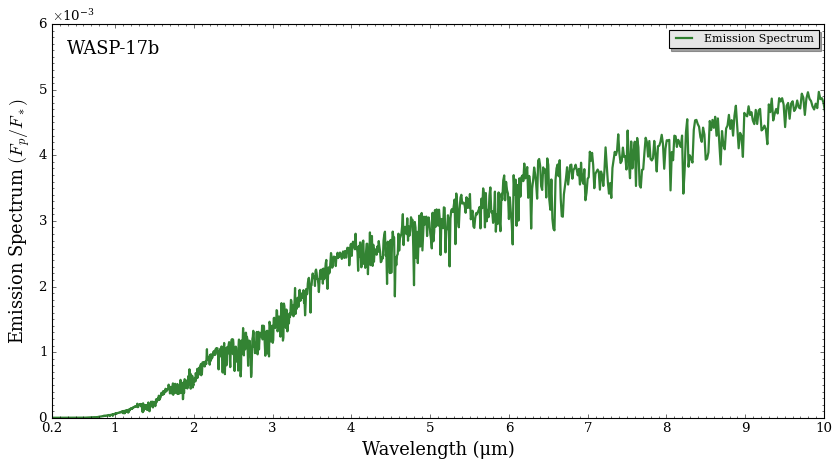

In [16]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate planet emission spectrum
Fp_Fs = compute_spectrum(planet, star, model, atmosphere, opac_sampling, wl, 
                         spectrum_type = 'emission')   # Note the change in spectrum type

spectra = []
spectra = plot_collection(Fp_Fs, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 500, plot_full_res = False,
                        spectra_labels = ['Emission Spectrum'],
                        y_unit = 'Fp/Fs',  # This switches plot units from transmission to emission spectra
                        colour_list = ['darkgreen'],
                        # plt_label = 'Ultra-hot Jupiter Dayside Emission',
                        wl_axis = 'linear', wl_max = 10.0,
                        figure_shape = 'wide')

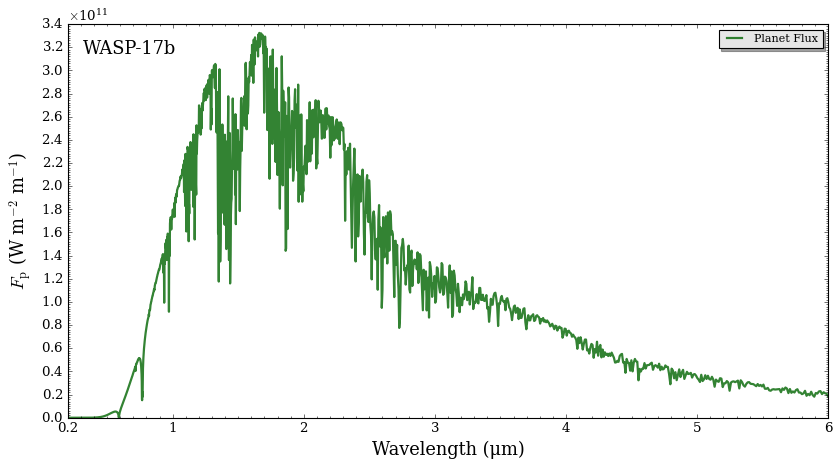

In [17]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate planet emission spectrum
Fp_Fs = compute_spectrum(planet, star, model, atmosphere, opac_sampling, wl, 
                         spectrum_type = 'emission')   # Note the change in spectrum type
Fp = (Fp_Fs * F_s * R_s**2) / R_p**2
spectra = []
spectra = plot_collection(Fp, wl, collection = spectra)

# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 500, plot_full_res = False,
                        spectra_labels = ['Planetary Flux (R=500)'],
                        y_unit = 'Fp',  # This switches plot units from transmission to emission spectra
                        colour_list = ['darkgreen'],
                        # plt_label = 'Ultra-hot Jupiter Dayside Emission',
                        wl_axis = 'linear', wl_max = 6.0,
                        figure_shape = 'wide')

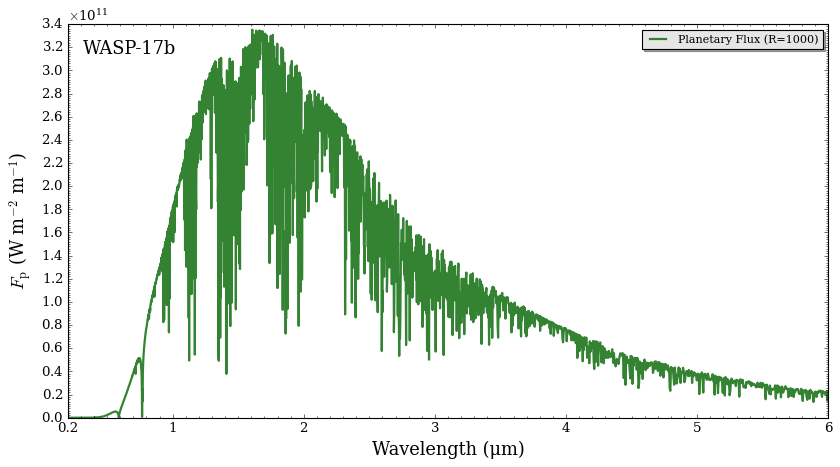

In [24]:
# Produce figure and save to file
fig_spec = plot_spectra(spectra, planet, R_to_bin = 1000, plot_full_res = False,
                        spectra_labels = ['Planetary Flux (R=1000)'],
                        y_unit = 'Fp',  # This switches plot units from transmission to emission spectra
                        colour_list = ['darkgreen'],
                        # plt_label = 'Ultra-hot Jupiter Dayside Emission',
                        wl_axis = 'linear', wl_max = 6.0,
                        figure_shape = 'wide')

In [23]:
path_wasp17b = '/home/gauravs/APAM/RT_code/WASP17/spectra/'
np.save(path_wasp17b+'poseidon_Fp_Fs',Fp_Fs)
np.save(path_wasp17b+'poseidon_Fp',Fp)

In [ ]:
### Emission Spectra and Planetary Flux for benchmarking is created and 
### saved  in the spectra folder for comparison with our models 
### Using Poseidon Opacity Database and Sampling
### Spectra computed using POSEIDON (at R=1000)
##### (env: poseidon_test)